<a href="https://colab.research.google.com/github/milenDG/ADS/blob/main/ADS_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [1]:
!pip install -q matplotlib -U

     |████████████████████████████████| 11.2 MB 5.4 MB/s 
     |████████████████████████████████| 930 kB 60.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# Restart the runtime
import os
os.kill(os.getpid(), 9)

In [15]:
# Imported Libraries
import numpy as np # linear algebra
from scipy import stats
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math
from google.colab import drive # Load the Drive helper and mount
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

# Classification Helpers
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Classifier Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Other Libraries
from sklearn.pipeline import make_pipeline

# Under-sampling
from imblearn.under_sampling import NearMiss, ClusterCentroids

# Over-sampling
from imblearn.over_sampling import SMOTE, ADASYN


# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

ADS_FOLDER = '/content/drive/My Drive/ADS/'

clf = LinearSVC()

Mounted at /content/drive


#Helper functions

In [63]:
def plot_hist_of_col(df, col, title):
    df = df.replace({'Class': {0: "Valid", 1: "Fraud"}})

    plt.figure(figsize=(8, 6))
    ax = sns.kdeplot(data=df, x=col, alpha=0.3, hue='Class', hue_order=['Fraud', 'Valid'], common_norm=False, fill=True)
    ax.set_title("{} Histogram Distribution of Column {}".format(title, col))
    ax.set_xlabel(col)
    ax.set_ylabel("Observations%")
    plt.show()
    print()

def plot_pairplots(df, cols, title):
    pp = sns.pairplot(df.replace({'Class': {0: "Valid", 1: "Fraud"}})[cols + ['Class']], hue='Class', hue_order=['Fraud', 'Valid'], size=3, plot_kws=dict(linewidth=0.3, alpha=0.6))

    fig = pp.fig 
    fig.subplots_adjust(top=0.92, wspace=0.3)
    t = fig.suptitle('{} Data Pairwise Plots'.format(title), fontsize=20)

def kernel_data_estimate(df, cols, title, max_records=-1):
    df_pca = convert_data_to_2d(df, cols, max_records)
    classes = df['Class'].replace(0, 'Valid').replace(1, 'Fraud')

    plt.figure(figsize=(8, 6))
    ax = sns.kdeplot(df_pca['PC1'], df_pca['PC2'], hue=classes, hue_order=['Fraud', 'Valid'], alpha=0.85, fill=True, common_norm=False)
    ax.set_title("{} Kernel Density Estimate".format(title), fontsize=20)

def convert_data_to_2d(df, cols, max_records=-1):
    length = df.shape[0] if (max_records == -1) else min(df.shape[0], max_records)
    df = df[:length]

    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df[cols]).transpose()

    df_new = pd.DataFrame()
    df_new['PC1'] = df_pca[0]
    df_new['PC2'] = df_pca[1]

    return df_new

#Data Preparation
1. Completely shuffle the data and do not remember any indexes
2. Split the data in train and test dataset respectively in 80% to 20%
3. Convert the single DataFrame with class to DataFrame without class and another array for the class


In [6]:
df = pd.read_csv(ADS_FOLDER + 'creditcard.csv')
df = df.sample(frac=1, ignore_index=True)

# Correlation Matrix

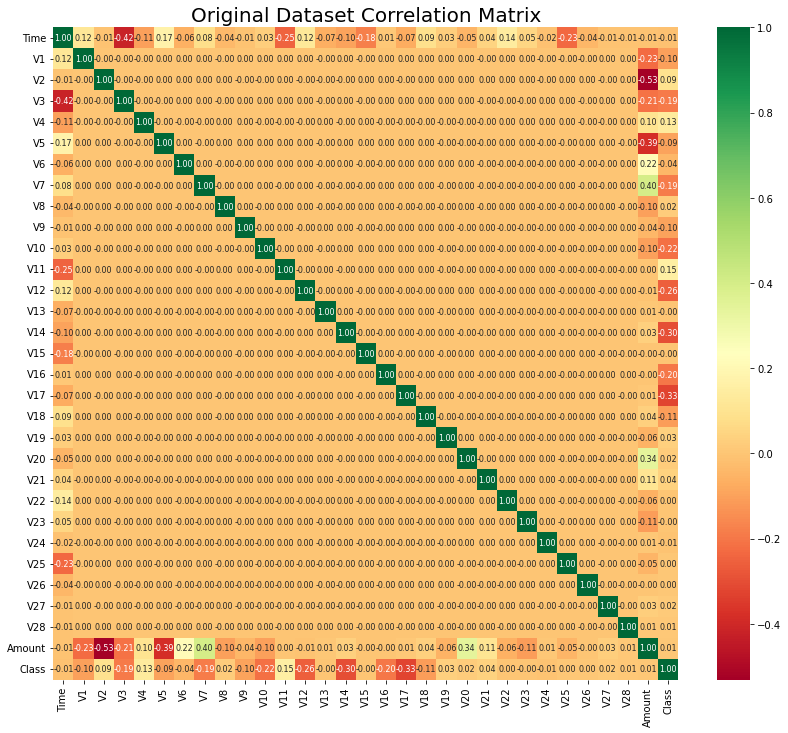

In [5]:
sub_sample_corr = df.corr()
plt.figure(figsize=(14,12))
ax = sns.heatmap(sub_sample_corr, cmap='RdYlGn', annot=True, annot_kws={'size':8}, fmt=".2f")
ax.set_title('Original Dataset Correlation Matrix', fontsize=20)
plt.show()

# Statistics (mean, median, std) Analysis

In [6]:
cols = ['V10', 'V12', 'V14', 'V16', 'V17']
df_stats = df.replace({'Class': {0: "Valid", 1: "Fraud"}}).groupby(['Class'])[cols].agg(['mean', 'std', 'median'])
means = df_stats.loc[:,(cols, ['mean'])].droplevel(1, axis=1)
stds = df_stats.loc[:,(cols, ['std'])].droplevel(1, axis=1)
median = df_stats.loc[:,(cols, ['median'])].droplevel(1, axis=1)

df_new = pd.DataFrame()
df_new["Column"] = means.columns.tolist() * 3
df_new["Stats"] = means.transpose()['Fraud'].tolist() + stds.transpose()['Fraud'].tolist() + median.transpose()['Fraud'].tolist()
df_new["Stat"] = ['Mean'] * 5 + ['SD'] * 5 + ['Median'] * 5

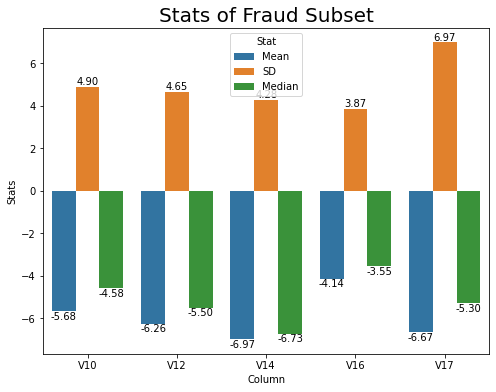

In [8]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_new, x='Column', y='Stats', hue='Stat')
ax.set_title('Stats of Fraud Subset', fontsize=20)
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")

# IQR Analysis

In [6]:
df_valid = df[df['Class'] == 0]

q1_valid = df_valid.quantile(0.25)
q2_valid = df_valid.quantile(0.75) - q1_valid
q_valid = (q2_valid - q1_valid).drop('Class').drop('Time').drop('Amount')

df_fraud = df[df['Class'] == 1]

q1_fraud = df_fraud.quantile(0.25)
q2_fraud = df_fraud.quantile(0.75) - q1_fraud
q_fraud = (q2_fraud - q1_fraud).drop('Class').drop('Time').drop('Amount')

df_new = pd.DataFrame()
df_new["Column"] = q_valid.index.values.tolist() * 2
df_new["Col IQR"] = q_fraud.values.tolist() + q_valid.values.tolist()
df_new["Class"] = ['Fraud'] * len(q_valid.index.values) + ['Valid'] * len(q_valid.index.values)

Text(0.5, 1.0, 'IQR by Column of both classes')

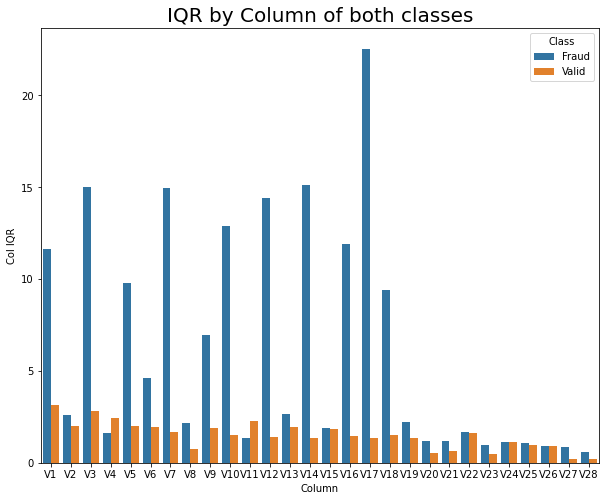

In [ ]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(data=df_new, x='Column', y='Col IQR', hue='Class')
ax.set_title('IQR by Column of both classes', fontsize=20)

In [ ]:
df_pca = convert_data_to_2d(df, ['V10', 'V11', 'V12', 'V16', 'V17'])
df_pca_mean = np.asarray(df_pca.mean())

distances = pd.Series()
for index, row in df_pca.iterrows():
    distances.at[len(distances.index)] = np.linalg.norm(np.asarray(row) - df_pca_mean)

distances.sort_values(inplace=True)
distances_len = len(distances)
IQR_ids = distances.take(list(range(math.floor(distances_len * 0.25), math.ceil(distances_len * 0.75)))).index.values

In [ ]:
df_iqr = df.iloc[IQR_ids]
df_non_iqr = df.loc[set(df.index) - set(IQR_ids)]

In [ ]:
part_in_iqr = list(df_iqr['Class'].value_counts() / [len(df_valid), len(df_fraud)])
part_out_iqr = list(df_non_iqr['Class'].value_counts() / [len(df_valid), len(df_fraud)])
part_in_iqr.reverse()
part_out_iqr.reverse()

df_new = pd.DataFrame()
df_new["Interquartile Range"] = ['Inside IQR'] * 2 + ['Outside IQR'] * 2
df_new["Percentage of Values"] = part_in_iqr + part_out_iqr
df_new["Class"] = ['Fraud', 'Valid'] * 2

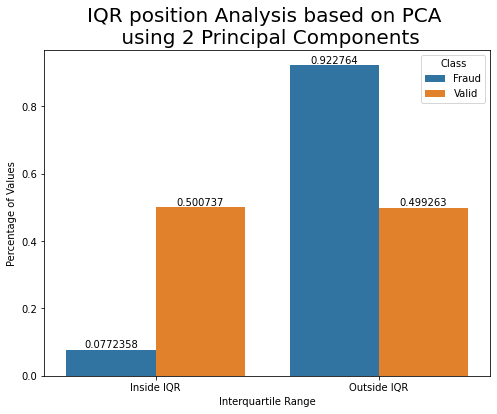

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_new, x='Interquartile Range', y='Percentage of Values', hue='Class')
ax.set_title('IQR position Analysis based on PCA \n using 2 Principal Components', fontsize=20)
for container in ax.containers:
    ax.bar_label(container)

# Z-score Analysis

In [9]:
z_scores = np.linalg.norm(np.absolute(stats.zscore(df)), axis=1)
z_score_mean = z_scores.mean()
z_score_std = z_scores.std()

In [14]:
df_z = df.copy().replace({'Class': {0: "Valid", 1: "Fraud"}})
df_z['Z'] = z_scores
df_fraud_z = df_z[df_z['Class'] == 'Fraud']['Z']
df_valid_z = df_z[df_z['Class'] == 'Valid']['Z']

In [23]:
print(df_fraud_z.describe())
print()
print(df_valid_z.describe())

count    492.000000
mean      33.802553
std       10.257100
min       24.259796
25%       26.615212
50%       29.370316
75%       36.428246
max       81.761125
Name: Z, dtype: float64

count    284315.000000
mean          4.743628
std           2.528381
min           2.146495
25%           3.560288
50%           4.289776
75%           5.209510
max         218.096782
Name: Z, dtype: float64


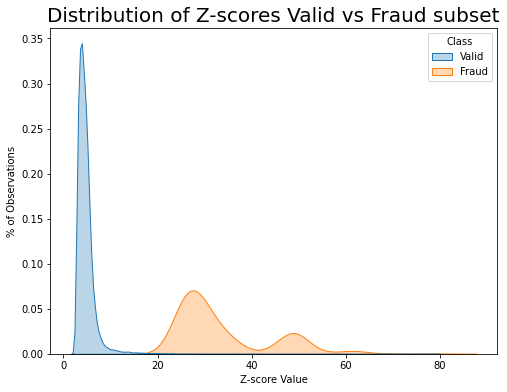

In [27]:
plt.figure(figsize=(8, 6))
ax = sns.kdeplot(data=df_z[df_z['Z'] < 80], x='Z', hue='Class', alpha=0.3, fill=True, cumulative=False, common_norm=False)
ax.set_title("Distribution of Z-scores Valid vs Fraud subset", fontsize=20)
ax.set_xlabel("Z-score Value")
ax.set_ylabel("% of Observations")
plt.show()

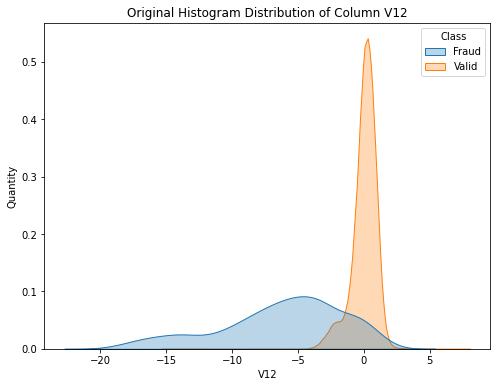

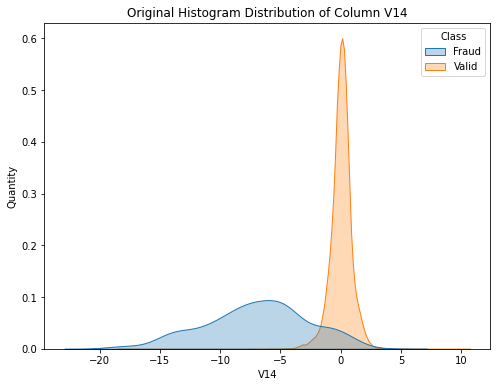

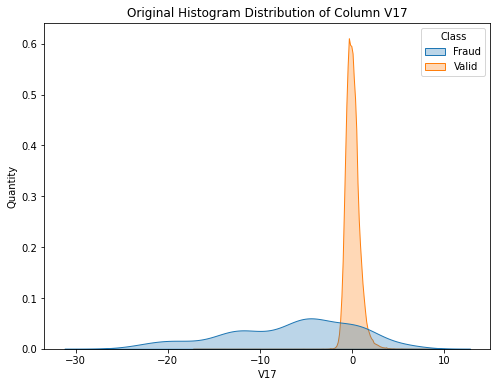

In [ ]:
plot_hist_of_col(df, "V12", "Original")
plot_hist_of_col(df, "V14", "Original")
plot_hist_of_col(df, "V17", "Original")

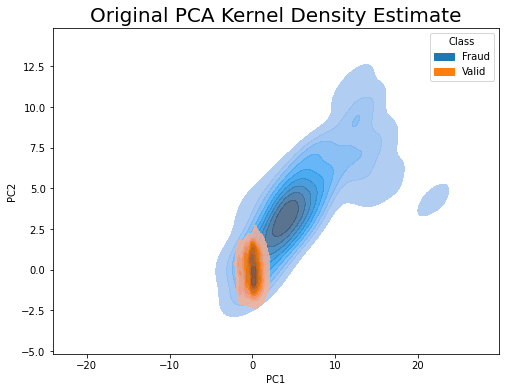

In [9]:
kernel_data_estimate(df, ['V10', 'V11', 'V12', 'V16', 'V17'], 'Original PCA')

In [11]:
train, test = train_test_split(df, test_size=0.2)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train_y = train['Class']
train_X = train.drop('Class', 1)

# Create testing dataset but having balanced data
test_y = test['Class']
test_X = test.drop('Class', 1)
test_frauds_count = sum(test_y == 1)
test_X = pd.concat([test_X[test_y == 0][:test_frauds_count], test_X[test_y == 1]])
test_y = pd.concat([test_y[test_y == 0][:test_frauds_count], test_y[test_y == 1]])

Text(0.5, 1.0, 'Original Full Data Distribution \n 284315 (0.17%) Valid vs 492 (0.17%) Fraud')

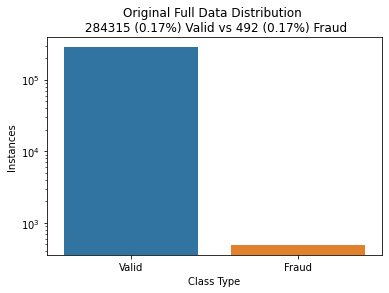

In [ ]:
classes = df['Class']
total_count = int(classes.describe()['count'])
total_0, total_1 = classes.value_counts()

plt.figure(figsize=(6,4))
plot = sns.countplot(data=classes.replace(0, 'Valid').replace(1, 'Fraud').to_frame(), x='Class')
plot.set(yscale="log")
plot.set_xlabel('Class Type')
plot.set_ylabel('Instances')
plot.set_title('Original Full Data Distribution \n {} ({:.2%}) Valid vs {} ({:.2%}) Fraud'.format(total_0, total_1/total_count, total_1, total_1/total_count))

Text(0.5, 1.0, 'Original Train Distribution \n 227443 (99.82%) Valid vs 402 (0.18%) Fraud')

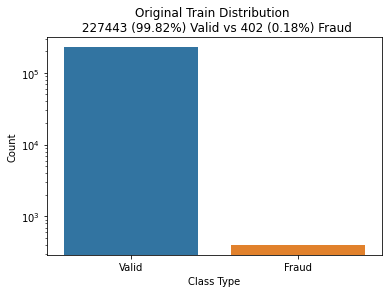

In [ ]:
train_count = int(train_y.describe()['count'])
train_0, train_1 = train_y.value_counts()

plt.figure(figsize=(6,4))
plot = sns.countplot(data=train_y.replace(0, 'Valid').replace(1, 'Fraud').to_frame(), x='Class')
plot.set(yscale="log")
plot.set_xlabel('Class Type')
plot.set_ylabel('Count')
plot.set_title('Original Train Distribution \n {} ({:.2%}) Valid vs {} ({:.2%}) Fraud'.format(train_0, train_0/train_count, train_1, train_1/train_count))

Text(0.5, 1.0, 'Original Test Distribution \n 56872 (99.84%) Valid vs 90 (0.16%) Fraud')

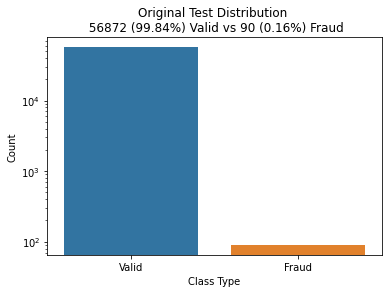

In [ ]:
test_count = int(test_y.describe()['count'])
test_0, test_1 = test_y.value_counts()

plt.figure(figsize=(6,4))
plot = sns.countplot(data=test_y.replace(0, 'Valid').replace(1, 'Fraud').to_frame(), x='Class')
plot.set(yscale="log")
plot.set_xlabel('Class Type')
plot.set_ylabel('Count')
plot.set_title('Original Test Distribution \n {} ({:.2%}) Valid vs {} ({:.2%}) Fraud'.format(test_0, test_0/test_count, test_1, test_1/test_count))

In [17]:
clf.fit(train_X, train_y)
print(clf.score(test_X, test_y))

0.5825242718446602


#Under-sampling (near miss)

In [61]:
ccu = NearMiss(version=2)
train_X_undersampled, train_y_undersampled = ccu.fit_resample(train_X, train_y)
train_X_undersampled['Class'] = train_y_undersampled
train_X_undersampled = train_X_undersampled.sample(frac=1, ignore_index=True)

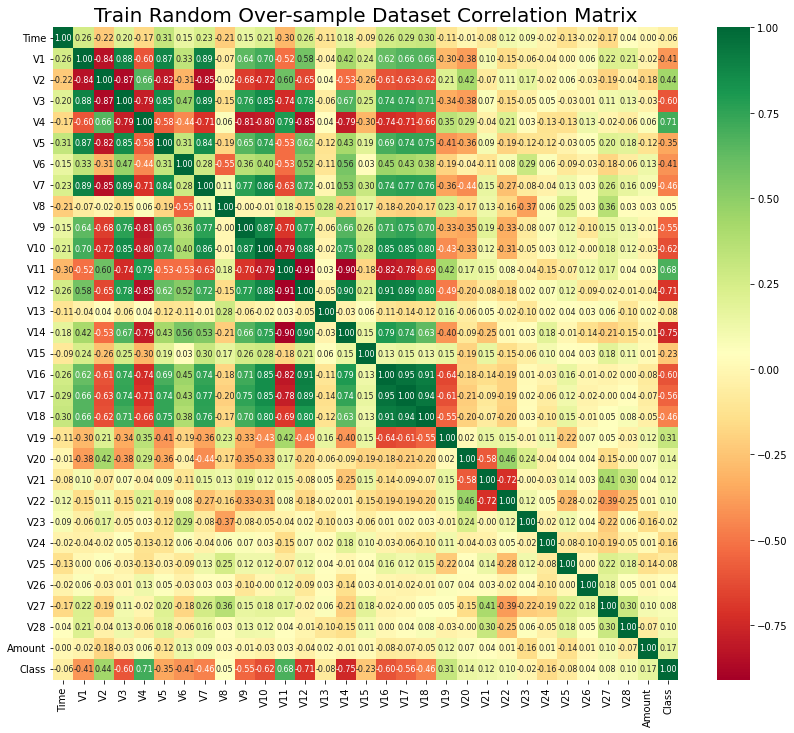

In [53]:
sub_sample_corr = train_X_undersampled.corr()
plt.figure(figsize=(14,12))
ax = sns.heatmap(sub_sample_corr, cmap='RdYlGn', annot=True, annot_kws={'size':8}, fmt=".2f")
ax.set_title('Train Random Over-sample Dataset Correlation Matrix', fontsize=20)
plt.show()

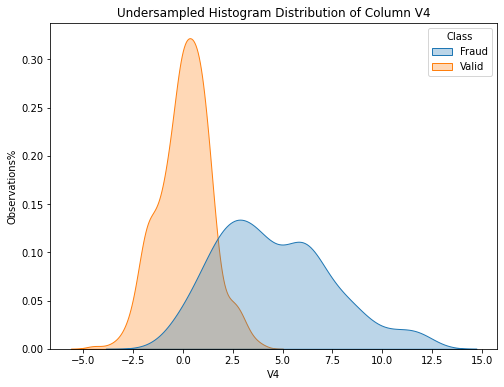

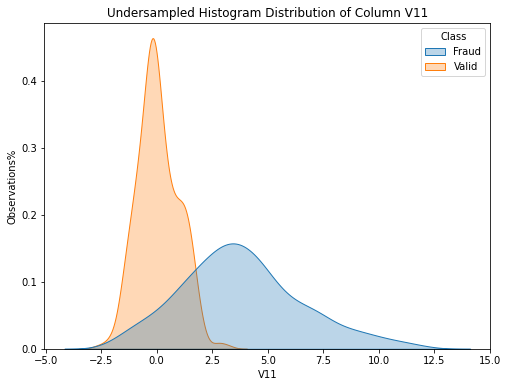

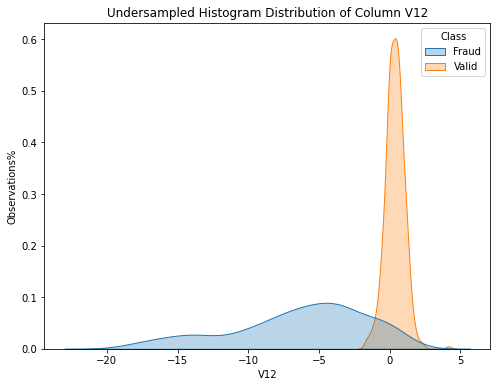

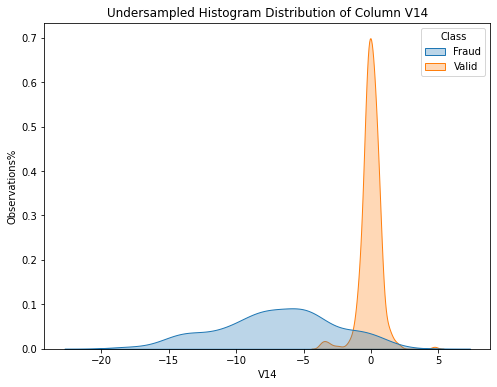

In [54]:
plot_hist_of_col(train_X_undersampled, "V4", "Undersampled")
plot_hist_of_col(train_X_undersampled, "V11", "Undersampled")
plot_hist_of_col(train_X_undersampled, "V12", "Undersampled")
plot_hist_of_col(train_X_undersampled, "V14", "Undersampled")

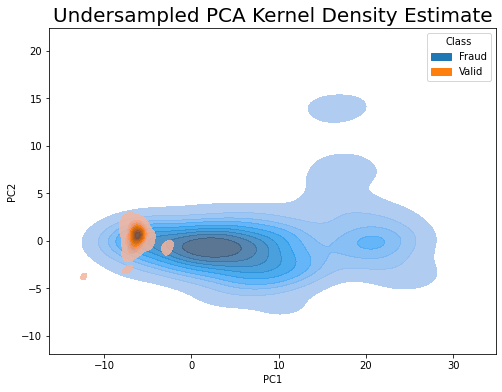

In [55]:
kernel_data_estimate(train_X_undersampled, ['V4', 'V10', 'V11', 'V12', 'V14'], 'Undersampled PCA')

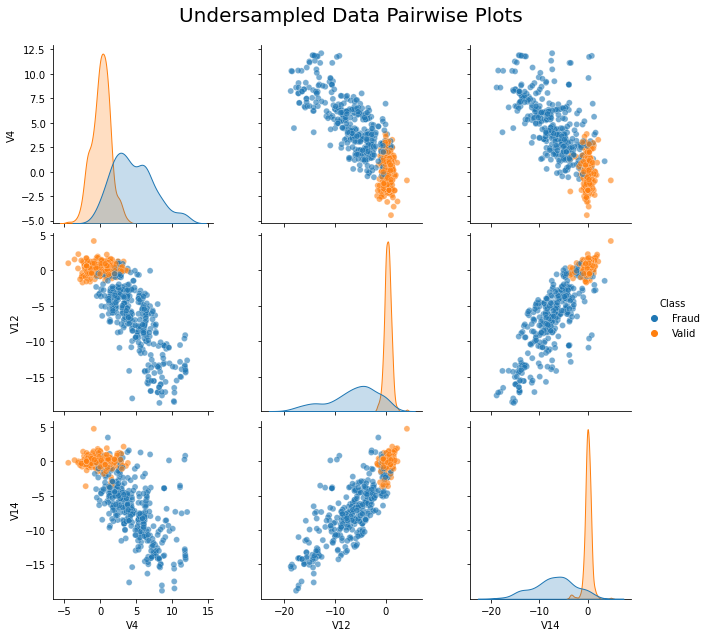

In [64]:
plot_pairplots(train_X_undersampled, ['V4', 'V12', 'V14'], 'Undersampled')

In [57]:
train_y_undersampled = train_X_undersampled['Class']
train_X_undersampled = train_X_undersampled.drop('Class', 1)

Text(0.5, 1.0, 'Train Random Over-sample Distribution \n 389 (50.0%) Valid vs 389 (50.0%) Fraud')

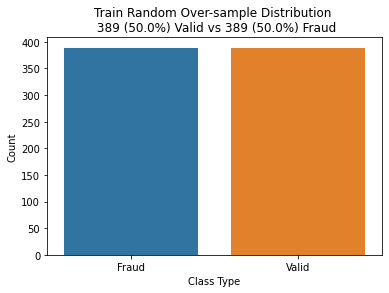

In [58]:
train_undersampled_count = int(train_y_undersampled.describe()['count'])
train_0_undersampled, train_1_undersampled = train_y_undersampled.value_counts()

plt.figure(figsize=(6,4))
plot = sns.countplot(data=train_y_undersampled.replace(0, 'Valid').replace(1, 'Fraud').to_frame(), x='Class')
plot.set_xlabel('Class Type')
plot.set_ylabel('Count')
plot.set_title('Train Random Over-sample Distribution \n {} ({:.1%}) Valid vs {} ({:.1%}) Fraud'.format(train_0_undersampled, 
                                                                                                        train_0_undersampled/train_undersampled_count, 
                                                                                                        train_1_undersampled, 
                                                                                                        train_1_undersampled/train_undersampled_count))

In [59]:
clf.fit(train_X_undersampled, train_y_undersampled)
print(clf.score(test_X, test_y))

0.7233009708737864


#Over-sampling (ADASYN)

2. Perform Synthetic Minority Over-sampling Technique (ADASYN)

In [27]:
smo = ADASYN()
train_X_oversampled, train_y_oversampled = smo.fit_resample(train_X, train_y)
train_X_oversampled['Class'] = train_y_oversampled
train_X_oversampled = train_X_oversampled.sample(frac=1, ignore_index=True)

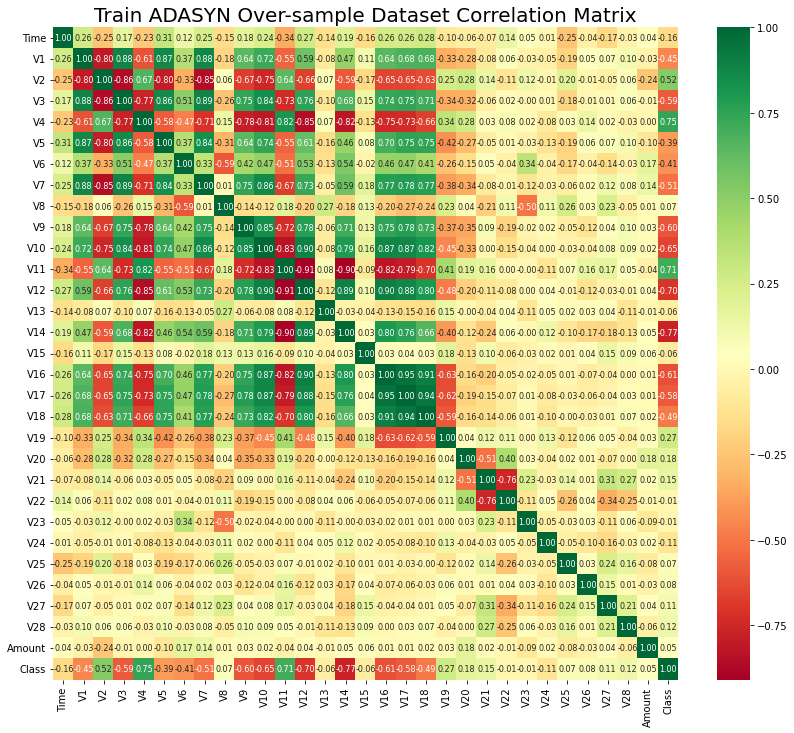

In [ ]:
sub_sample_corr = train_X_oversampled.corr()
plt.figure(figsize=(14,12))
ax = sns.heatmap(sub_sample_corr, cmap='RdYlGn', annot=True, annot_kws={'size':8}, fmt=".2f")
ax.set_title('Train ADASYN Over-sample Dataset Correlation Matrix', fontsize=20)
plt.show()

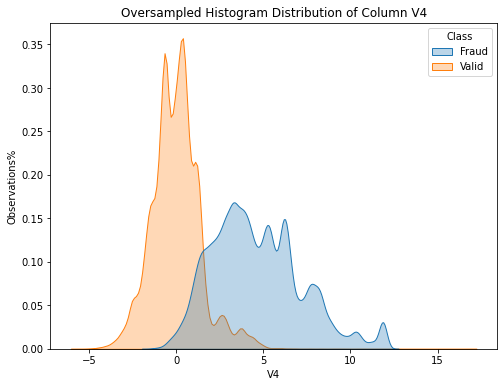

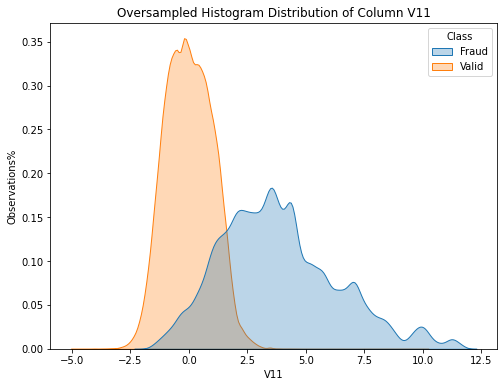

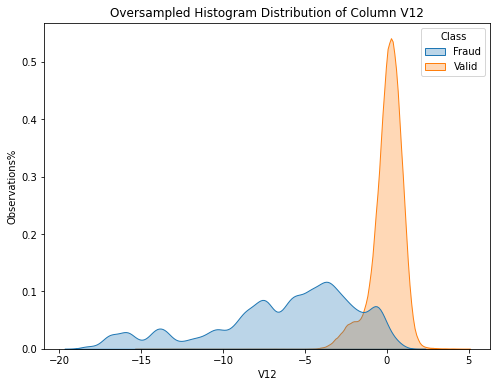

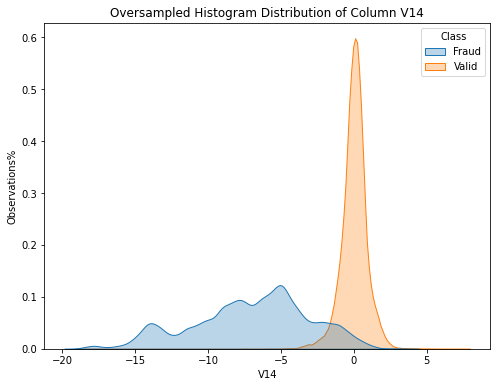

In [ ]:
plot_hist_of_col(train_X_oversampled, "V4", "Oversampled")
plot_hist_of_col(train_X_oversampled, "V11", "Oversampled")
plot_hist_of_col(train_X_oversampled, "V12", "Oversampled")
plot_hist_of_col(train_X_oversampled, "V14", "Oversampled")

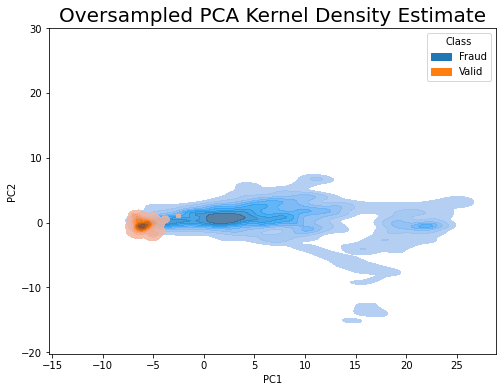

In [28]:
kernel_data_estimate(train_X_oversampled, ['V4', 'V10', 'V11', 'V12', 'V14'], 'Oversampled PCA')

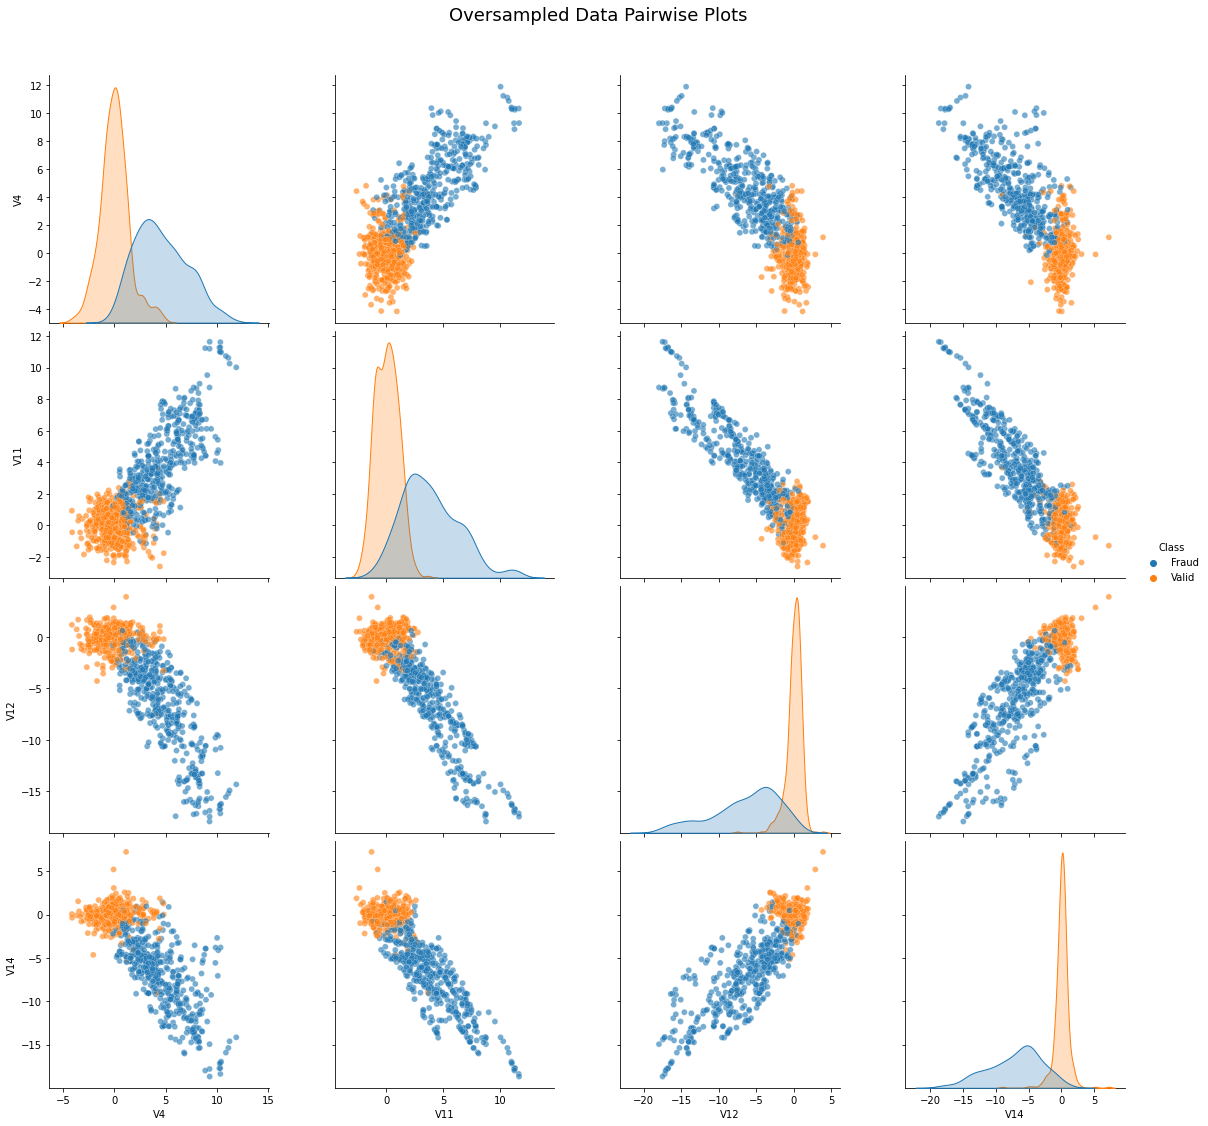

In [ ]:
plot_pairplots(train_X_oversampled.sample(1000), ['V4', 'V11', 'V12', 'V14'], 'Oversampled')

In [23]:
train_y_oversampled = train_X_oversampled['Class']
train_X_oversampled = train_X_oversampled.drop('Class', 1)

Text(0.5, 1.0, 'Train SMOTE Over-sample Distribution \n 227454 (50.0%) Valid vs 227454 (50.0%) Fraud')

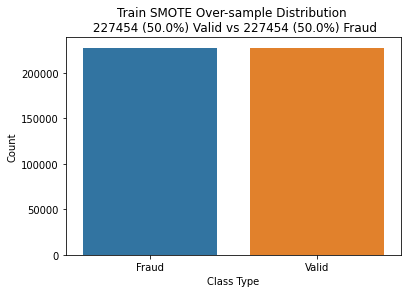

In [ ]:
train_oversampled_count = int(train_y_oversampled.describe()['count'])
train_0_oversampled, train_1_oversampled = train_y_oversampled.value_counts()

plt.figure(figsize=(6,4))
plot = sns.countplot(data=train_y_oversampled.replace(0, 'Valid').replace(1, 'Fraud').to_frame(), x='Class')
plot.set_xlabel('Class Type')
plot.set_ylabel('Count')
plot.set_title('Train SMOTE Over-sample Distribution \n {} ({:.1%}) Valid vs {} ({:.1%}) Fraud'.format(train_0_oversampled, 
                                                                                                       train_0_oversampled/train_oversampled_count, 
                                                                                                       train_1_oversampled, 
                                                                                                       train_1_oversampled/train_oversampled_count))

In [25]:
clf.fit(train_X_oversampled, train_y_oversampled)
print(clf.score(test_X, test_y))

0.8883495145631068


#Combination of Over- and Under-sampling

#Ensamble Learning